#  <u> 1st step : Load

Open the final merge table of the 'outlier part '

In [145]:
# we import the useful librairies 

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import functools
import os
import plotly.express as px
from scipy.stats import shapiro
import ipywidgets as widgets
from ipywidgets import Layout
from ipywidgets import interact, interact_manual


# we open and read the merge table of all indicators
silver_dataset = pd.read_csv ('./data/SilverDataset.csv')
silver_dataset = silver_dataset.drop(silver_dataset.columns[0], axis = 1)
silver_dataset

Code  Year   Deaths  Fertility  GDP   GenderInequality  LifeExpectancy  \
0      ABW  1950      NaN        NaN   NaN               NaN            57.2   
1      ABW  1951      NaN        NaN   NaN               NaN            57.7   
2      ABW  1952      NaN        NaN   NaN               NaN            58.7   
3      ABW  1953      NaN        NaN   NaN               NaN            59.5   
4      ABW  1954      NaN        NaN   NaN               NaN            60.4   
...    ...   ...      ...        ...   ...               ...             ...   
21097  ZWE  2017  26069.0     3.7064   NaN             0.532            60.7   
21098  ZWE  2018  24648.0     3.6591   NaN             0.535            61.4   
21099  ZWE  2019  24006.0     3.5994   NaN             0.533            61.3   
21100  ZWE  2020  23533.0     3.5451   NaN             0.533            61.1   
21101  ZWE  2021      NaN     3.4908   NaN             0.532            59.3   

       tertiary_education  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  
...                   ...  
21097                 NaN  
21098                 NaN  
21099                 NaN  
21100                 NaN  
21101                 NaN  

[21102 rows x 8 columns]

#  <u> 2nd step : Filter by year 


We notice that we don't have data before 1830 apart from one country, it will lead us to filter the dataset and remove the data before the years 1825 

In [146]:
silver_dataset = silver_dataset[silver_dataset['Year'] > 1830]
silver_dataset

Code  Year   Deaths  Fertility  GDP   GenderInequality  LifeExpectancy  \
0      ABW  1950      NaN        NaN   NaN               NaN            57.2   
1      ABW  1951      NaN        NaN   NaN               NaN            57.7   
2      ABW  1952      NaN        NaN   NaN               NaN            58.7   
3      ABW  1953      NaN        NaN   NaN               NaN            59.5   
4      ABW  1954      NaN        NaN   NaN               NaN            60.4   
...    ...   ...      ...        ...   ...               ...             ...   
21097  ZWE  2017  26069.0     3.7064   NaN             0.532            60.7   
21098  ZWE  2018  24648.0     3.6591   NaN             0.535            61.4   
21099  ZWE  2019  24006.0     3.5994   NaN             0.533            61.3   
21100  ZWE  2020  23533.0     3.5451   NaN             0.533            61.1   
21101  ZWE  2021      NaN     3.4908   NaN             0.532            59.3   

       tertiary_education  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  
...                   ...  
21097                 NaN  
21098                 NaN  
21099                 NaN  
21100                 NaN  
21101                 NaN  

[20905 rows x 8 columns]

#  <u> 3rd step : Count the number of NaN values 


We can count how many NaN values we have, it corresponds to the number of outliers we have removed in the step forward

In [147]:
silver_dataset.isna().sum().sum()

61621

Then the can count the number of unique countries taht we have, and put them in a list

In [148]:
nb_countries_serie = silver_dataset.Code.value_counts()
nb_countries_serie 

Code
NOR         191
GBR         191
CHL         191
NLD         191
DNK         191
           ... 
OWID_SRM     56
OWID_CZS     44
OWID_AUH     40
OWID_GFR     40
OWID_CIS      9
Name: count, Length: 243, dtype: int64

We can do the same thing with an other method

In [149]:
nb_countries_df  = silver_dataset.groupby(by='Code', as_index=False).nunique()


In [150]:
list_diff_countries = nb_countries_serie.index.tolist()

#  <u> 4th step : Reducing the number of NaN values 



### First to reduce the missing data we do a linear interpolation

In [151]:
df = silver_dataset

# we take the first country of the list 
dat=df.loc[df.loc[:, 'Code'] == list_diff_countries[0]]

# we call the interpolate function
datc=dat.interpolate(method="linear")
data=datc

#Then we do that for the rest of teh countries 
for i in range(1,len(list_diff_countries)):
    dat=df.loc[df.loc[:, 'Code'] == list_diff_countries[i]]
    datc=dat.interpolate(method="linear")
    
    # and we concatenate the new data with the previous data interpolated
    data=pd.concat((data, datc), axis = 0)
    
#Finally we calculate the number of NaN values     
data.isna().sum().sum()

51200

We can observe that it reduces a lot the number of missing datas

### Then we do the backward filling

In [152]:
dat=df.loc[df.loc[:, 'Code'] == list_diff_countries[0]]

#We call the backward filling method
datc=dat.fillna(method='bfill')
data=datc

for i in range(1,len(list_diff_countries)):
    dat=df.loc[df.loc[:, 'Code'] == list_diff_countries[i]]
    datc=dat.fillna(method='bfill')
    
    data=pd.concat((data, datc), axis = 0)
    
    
data.isna().sum().sum()

23875

It is not better , we try an other method ,
### the forward filling

In [153]:
dat=df.loc[df.loc[:, 'Code'] == list_diff_countries[0]]

#We call the forward filling method
datc=dat.fillna(method='ffill')
data=datc

for i in range(1,len(list_diff_countries)):
    dat=df.loc[df.loc[:, 'Code'] == list_diff_countries[i]]
    datc=dat.fillna(method='ffill')
    data=pd.concat((data, datc), axis = 0)
data.isna().sum().sum()

51200

To obtain a better result we gonna mix the methods

### First we mix the forward filling and the linear interpolation

In [154]:
dat=df.loc[df.loc[:, 'Code'] == list_diff_countries[0]]

#linear interpolation method
datc=dat.interpolate(method="linear")

#then forward filling method
datc=datc.fillna(method='ffill')
data=datc

for i in range(1,len(list_diff_countries)):
    dat=df.loc[df.loc[:, 'Code'] == list_diff_countries[i]]
    
    datc=dat.interpolate(method="linear")
    datc=datc.fillna(method='ffill')
    
    data=pd.concat((data, datc), axis = 0)
data.isna().sum().sum()

51200

It is not perfect 
### Then we mix the backward filling and the linear interpolation

In [155]:
dat=df.loc[df.loc[:, 'Code'] == list_diff_countries[0]]

#linear interpolation method
datc=dat.interpolate(method="linear")

#then forward filling method
datc=datc.fillna(method='bfill')
data=datc

for i in range(1,len(list_diff_countries)):
    dat=df.loc[df.loc[:, 'Code'] == list_diff_countries[i]]
    
    datc=dat.interpolate(method="linear")
    datc=datc.fillna(method='bfill')
    data=pd.concat((data, datc), axis = 0)
data.isna().sum().sum()

18622

It is perfect , but we can also
### mix the three methods

In [156]:
dat=df.loc[df.loc[:, 'Code'] == list_diff_countries[0]]

#linear interpollation method
datc=dat.interpolate(method="linear")

#backward filling method
datf=datc.fillna(method='bfill')

#forward filling method
datr=datf.fillna(method='ffill')
data=datr

for i in range(1,len(list_diff_countries)):
    dat=df.loc[df.loc[:, 'Code'] == list_diff_countries[i]]
    datc=dat.interpolate(method="linear")
    datc=datc.fillna(method='bfill')
    datc=datc.fillna(method='ffill')
    data=pd.concat((data, datc), axis = 0)
data.isna().sum().sum()

18622

In [157]:
data

Code  Year  Deaths  Fertility          GDP   GenderInequality  \
14098       NOR  1831  1427.0     2.5142  7.780508e+06             0.132   
14099       NOR  1832  1427.0     2.5142  7.023810e+06             0.132   
14100       NOR  1833  1427.0     2.5142  7.471980e+06             0.132   
14101       NOR  1834  1427.0     2.5142  8.048104e+06             0.132   
14102       NOR  1835  1427.0     2.5142  8.737864e+06             0.132   
...         ...   ...     ...        ...           ...               ...   
14701  OWID_CIS  2002     NaN        NaN  4.446153e+09               NaN   
14702  OWID_CIS  2003     NaN        NaN  4.490794e+09               NaN   
14703  OWID_CIS  2004     NaN        NaN  4.671829e+09               NaN   
14704  OWID_CIS  2005     NaN        NaN  4.854983e+09               NaN   
14705  OWID_CIS  2006     NaN        NaN  5.258874e+09               NaN   

       LifeExpectancy  tertiary_education  
14098           48.03                2.91  
14099           48.03                2.91  
14100           48.03                2.91  
14101           48.03                2.91  
14102           48.03                2.91  
...               ...                 ...  
14701             NaN                 NaN  
14702             NaN                 NaN  
14703             NaN                 NaN  
14704             NaN                 NaN  
14705             NaN                 NaN  

[20905 rows x 8 columns]

# <u> 5th step : Normalize the values 

Now, we are going to normalize the datas with the formula :
### zi=xi−min(x)/ max(x)−min(x)

In [158]:
dat=df.loc[df.loc[:, 'Code'] == list_diff_countries[0]]

all_colums = ['Deaths','Fertility','GDP ','GenderInequality','LifeExpectancy','tertiary_education']

#linear interpollation method and backward filling method
datc=dat.interpolate(method="linear")
datf=datc.fillna(method='bfill')

# use of the formula : zi=(xi−min(x))/ (max(x)−min(x))
datr[all_colums]=(datr[all_colums]-datr[all_colums].min())/(datr[all_colums].max()-datr[all_colums].min())
data=datr

# We do the same for all the countries
for i in range(1,len(list_diff_countries)):
    dat=df.loc[df.loc[:, 'Code'] == list_diff_countries[i]]
    
    datc=dat.interpolate(method="linear")
    datc=datc.fillna(method='bfill')
    
    datc[all_colums]=(datc[all_colums]-datc[all_colums].min())/(datc[all_colums].max()-datc[all_colums].min())
    data=pd.concat((data, datc), axis = 0)
    
data

Code  Year  Deaths  Fertility      GDP   GenderInequality  \
14098       NOR  1831     1.0   0.687195  0.000109               1.0   
14099       NOR  1832     1.0   0.687195  0.000000               1.0   
14100       NOR  1833     1.0   0.687195  0.000065               1.0   
14101       NOR  1834     1.0   0.687195  0.000148               1.0   
14102       NOR  1835     1.0   0.687195  0.000247               1.0   
...         ...   ...     ...        ...       ...               ...   
14701  OWID_CIS  2002     NaN        NaN  0.512971               NaN   
14702  OWID_CIS  2003     NaN        NaN  0.539722               NaN   
14703  OWID_CIS  2004     NaN        NaN  0.648209               NaN   
14704  OWID_CIS  2005     NaN        NaN  0.757965               NaN   
14705  OWID_CIS  2006     NaN        NaN  1.000000               NaN   

       LifeExpectancy  tertiary_education  
14098        0.086731                 0.0  
14099        0.086731                 0.0  
14100        0.086731                 0.0  
14101        0.086731                 0.0  
14102        0.086731                 0.0  
...               ...                 ...  
14701             NaN                 NaN  
14702             NaN                 NaN  
14703             NaN                 NaN  
14704             NaN                 NaN  
14705             NaN                 NaN  

[20905 rows x 8 columns]

In [134]:
# We do  reset the index and rename a column 

new_data=data.reset_index()
new_data.columns.names = ['']
new_data.rename(columns = {'index':'Unnamed'}, inplace = True)
new_data

Unnamed      Code  Year  Deaths  Fertility      GDP   GenderInequality  \
0        14098       NOR  1831     1.0   0.687195  0.000109               1.0   
1        14099       NOR  1832     1.0   0.687195  0.000000               1.0   
2        14100       NOR  1833     1.0   0.687195  0.000065               1.0   
3        14101       NOR  1834     1.0   0.687195  0.000148               1.0   
4        14102       NOR  1835     1.0   0.687195  0.000247               1.0   
...        ...       ...   ...     ...        ...       ...               ...   
20900    14701  OWID_CIS  2002     NaN        NaN  0.512971               NaN   
20901    14702  OWID_CIS  2003     NaN        NaN  0.539722               NaN   
20902    14703  OWID_CIS  2004     NaN        NaN  0.648209               NaN   
20903    14704  OWID_CIS  2005     NaN        NaN  0.757965               NaN   
20904    14705  OWID_CIS  2006     NaN        NaN  1.000000               NaN   

       LifeExpectancy  tertiary_education  
0            0.086731                 0.0  
1            0.086731                 0.0  
2            0.086731                 0.0  
3            0.086731                 0.0  
4            0.086731                 0.0  
...               ...                 ...  
20900             NaN                 NaN  
20901             NaN                 NaN  
20902             NaN                 NaN  
20903             NaN                 NaN  
20904             NaN                 NaN  

[20905 rows x 9 columns]

In [159]:
#we create the withoud clustering golden dataframe 
new_data.to_csv('./data/GoldenDataFrameWithoutCluster.csv')

#  <u> 6th step  :  Correlation matrix 

Now we are going to to the correlation matrix between indicators to find how to group our data
For that we use colours to show which indicators are correlated 

In [136]:
# then we drop the columns which are not the indicators columns 
tab_correlation = new_data.drop(new_data.columns[0], axis = 1)
tab_correlation = tab_correlation.drop(tab_correlation.columns[0], axis = 1)
tab_correlation = tab_correlation.drop(tab_correlation.columns[0], axis = 1)

tab_correlation = tab_correlation.corr(numeric_only= True)
tab_correlation.style.background_gradient(cmap='coolwarm')

[Text(0.5, 0, 'Deaths'),
 Text(1.5, 0, 'Fertility'),
 Text(2.5, 0, 'GDP '),
 Text(3.5, 0, 'GenderInequality'),
 Text(4.5, 0, 'LifeExpectancy'),
 Text(5.5, 0, 'tertiary_education')]

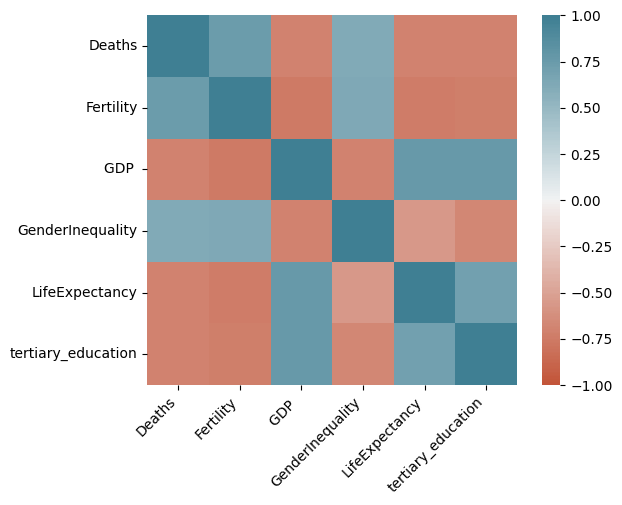

In [137]:
#correlation matrix heatmap for the data set

ax = sns.heatmap(
    tab_correlation, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

Then we plot the evolution of the value of the ratio between the values of the indicator and the values of the gdp for each year and each indicator 

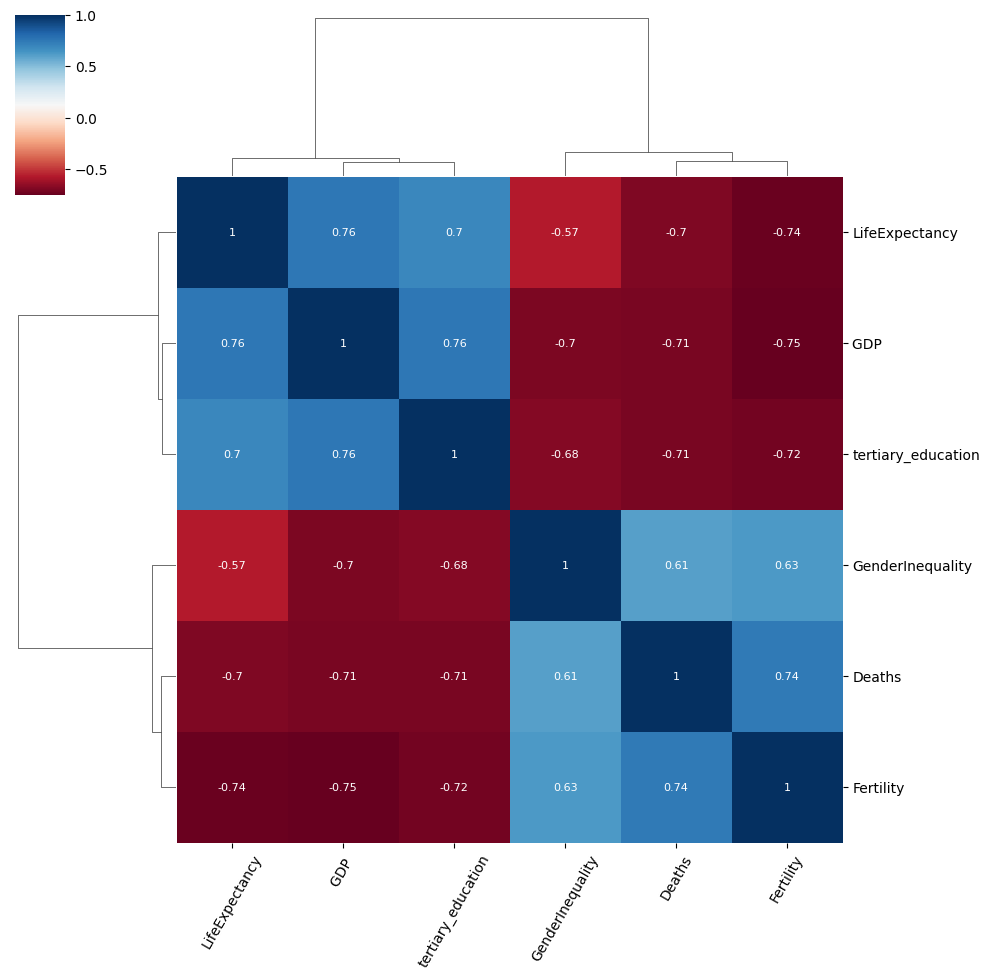

In [138]:
g = sns.clustermap(tab_correlation, 
                   method = 'complete', 
                   cmap   = 'RdBu', 
                   annot  = True, 
                   annot_kws = {'size': 8})

plt.setp(g.ax_heatmap.get_xticklabels(), rotation=60);

In [143]:
from sklearn.cluster import KMeans
df = new_data

variables = all_colums

# for each indicator we calculate the ratio between the values of the indicator and the values of the gdp 
for i in range(0, len(variables)):
    df[variables[i]]=df[variables[i]]/df['GDP ']

# then we plot the evolution of the value of each ratio for each year 
for i in range(0,len(variables)):
    a=px.line(df, x="Year", y=variables[i], color="Code", width=800, height=600)
    display(a)


# Step training : clustering 

We we try to find groups of similar values to use the k-means cluestering  method 


kmeans_kwargs = some arguments for teh kmeans method :

- init random = choose n_clusters observations (rows) at random from data for the initial centroids.

- n_init   =  Number of time the k-means algorithm will be run with different centroid seeds. 
The final results will be the best output of n_init consecutive runs in terms of inertia.

 - random state = Determines random number generation for centroid initialization. 
 
 
kmeans.inertia = return The final value of the inertia criterion (sum of squared distances to the closest centroid for all observations in the training set).


In [103]:
# first we import some useful librairies 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

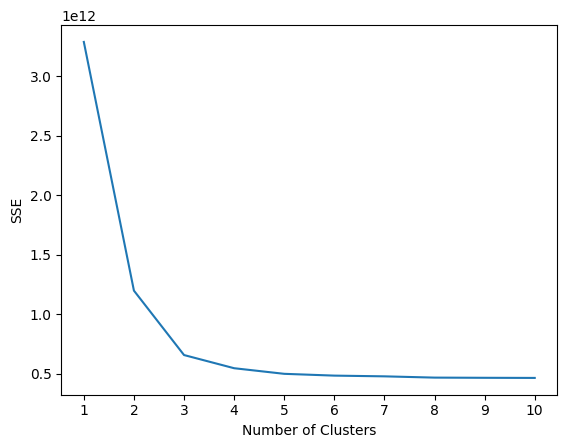

In [109]:
# Then we drop the Nan values 
init = df.dropna()

# then we drop the columns which are not the indicators columns 
scaled_df = df.drop(df.columns[1], axis = 1)
scaled_df = scaled_df.drop(scaled_df.columns[0], axis = 1)
scaled_df = scaled_df.drop(scaled_df.columns[0], axis = 1)

scaled_df = scaled_df.dropna()

#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10, 
"random_state": 1,
}

#create list to hold SSE values for each k
# SSE = sum of the squared Euclidean distances of each point to its closest centroid
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_df)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [110]:
#instantiate the k-means class, using optimal number of clusters
kmeans = KMeans(init="random", n_clusters=3, n_init=10, random_state=1)

#fit k-means algorithm to data
kmeans.fit(scaled_df)

#view cluster assignments for each observation
kmeans.labels_

array([2, 2, 2, ..., 2, 2, 2])

In [111]:
#append cluster assingments to original DataFrame
init['cluster'] = kmeans.labels_
init

C:\Users\lusais\AppData\Local\Temp\ipykernel_18756\713513040.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Unnamed Code  Year        Deaths     Fertility  GDP   GenderInequality  \
0        14098  NOR  1831   9175.648570   6305.463967   1.0          1.000000   
2        14100  NOR  1833  15492.331214  10646.259552   1.0          1.000000   
3        14101  NOR  1834   6778.513136   4658.163399   1.0          1.000000   
4        14102  NOR  1835   4050.741887   2783.651402   1.0          1.000000   
5        14103  NOR  1836   2864.085417   1968.186473   1.0          1.000000   
...        ...  ...   ...           ...           ...   ...               ...   
20570     8683  HRV  2017      0.032220      0.018887   1.0          0.166667   
20571     8684  HRV  2018      0.021480      0.060857   1.0          0.144144   
20572     8685  HRV  2019      0.010740      0.062478   1.0          0.117117   
20573     8686  HRV  2020      0.000000      0.057137   1.0          0.009009   
20574     8687  HRV  2021      0.000000      0.047026   1.0          0.000000   

       LifeExpectancy  tertiary_education  cluster  
0            0.086731                 0.0        2  
2            0.086731                 0.0        2  
3            0.086731                 0.0        2  
4            0.086731                 0.0        2  
5            0.086731                 0.0        2  
...               ...                 ...      ...  
20570        0.969231                 1.0        2  
20571        0.979487                 1.0        2  
20572        1.000000                 1.0        2  
20573        0.964103                 1.0        2  
20574        0.943590                 1.0        2  

[12767 rows x 10 columns]

In [112]:
nb_cluster= init.cluster.value_counts()
nb_cluster

cluster
2    12711
1       51
0        5
Name: count, dtype: int64

Then we classify by the categories of the Country groups defined before, to which we call "Income". It groups the nations with similar economies, so we can extract common conclusions from them.

We create a dictionary with the regions and the countries included in each one. Where we will relate the countries and their income and also apply the .map function to arrive to the final dataframe.

In [15]:
countries_by_income = {
    'low_income': ('AFG', 'BDI', 'CAF', 'COG', 'GMB', 'LBR', 'MWI', 'MLI', 'MOZ', 'NER', 'RWA', 'SLE', 'SDN', 'TGO', 'UGA', 'YEM'),
    'lower_middle_income': ('DZA', 'BGD', 'BOL', 'KHM', 'CMR', 'COD', 'CIV', 'EGY', 'SWZ', 'GHA', 'HTI', 'HND', 'IDN', 'JOR', 'IRN', 'KEN', 'KGZ', 'LSO', 'MRT', 'MNG', 'MAR', 'NPL', 'NIC', 'NER', 'PAK', 'PNG', 'PHL', 'SEN', 'LKA', 'TJK', 'TZA', 'TUN', 'UKR', 'VNM', 'ZMB', 'ZWE'),
    'upper_middle_income':('ALB', 'ARG', 'ARM', 'BLZ', 'BWA', 'BRA', 'BGR', 'CHN', 'COL', 'CRI', 'CUB', 'DOM', 'ECU', 'SLV', 'FJI', 'GAB', 'GTM', 'IDN', 'IRQ', 'JAM', 'KAZ', 'LBY', 'MYS', 'MDV', 'MUS', 'MEX', 'MDA', 'NAM', 'PRY', 'PER', 'ZAF', 'THA', 'TON'),
    'high_income':('AUS', 'AUT', 'BRB', 'BEL', 'CAN', 'CHL', 'HRV', 'CYP', 'DNK', 'EST', 'FIN', 'FRA', 'GUY', 'DEU', 'GRC', 'HUN', 'ISL', 'IRL', 'ISR', 'ITA', 'JPN', 'KWT', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 'NZL', 'NOR', 'PAN', 'POL', 'PRT', 'QAT', 'ROU', 'SGP', 'ESP', 'SWE', 'CHE', 'TTO', 'ARE', 'GBR', 'USA', 'URY'),
    }

all_countries = {}
for income in countries_by_income.keys():
  for country in countries_by_income[income]:
    all_countries[country] = income

In [16]:
data['Income']=data['Code'].map(all_countries)
Goldendataframe=data
Goldendataframe

Code  Year  Deaths  Fertility      GDP   GenderInequality  \
17794       SWE  1751     1.0   0.841083  0.000000               1.0   
17795       SWE  1752     1.0   0.841083  0.000000               1.0   
17796       SWE  1753     1.0   0.841083  0.000000               1.0   
17797       SWE  1754     1.0   0.841083  0.000000               1.0   
17798       SWE  1755     1.0   0.841083  0.000000               1.0   
...         ...   ...     ...        ...       ...               ...   
14701  OWID_CIS  2002     NaN        NaN  0.512971               NaN   
14702  OWID_CIS  2003     NaN        NaN  0.539722               NaN   
14703  OWID_CIS  2004     NaN        NaN  0.648209               NaN   
14704  OWID_CIS  2005     NaN        NaN  0.757965               NaN   
14705  OWID_CIS  2006     NaN        NaN  1.000000               NaN   

       LifeExpectancy  tertiary_education       Income  
17794        0.313325                 0.0  high_income  
17795        0.266810                 0.0  high_income  
17796        0.333589                 0.0  high_income  
17797        0.298895                 0.0  high_income  
17798        0.284618                 0.0  high_income  
...               ...                 ...          ...  
14701             NaN                 NaN          NaN  
14702             NaN                 NaN          NaN  
14703             NaN                 NaN          NaN  
14704             NaN                 NaN          NaN  
14705             NaN                 NaN          NaN  

[21102 rows x 9 columns]

In [19]:
#we create the golden dataframe 
Goldendataframe.to_csv('./data/GoldenDataFrame.csv')

for income, data in Goldendataframe.groupby('Income'):
   data.to_csv('./data/'+'{}.csv'.format(income))